# Research Data Analyst test

##  Import libraries
As a first step we need to impor the libaries for first review of the dataset.

In [404]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from sklearn.model_selection import train_test_split

from scipy import stats
from scipy.stats import norm, skew 


##  Load data
After loading the dataset to pandas DataFrame, we check the intial number of rows and columns, the dataset first rows and change the nominal columns to string data type.
**Notes: The EducationLevel variable wasn't transformed to a nominal variable beacause of it has ordinal meaning and i want it to be reflected in the prediction model.

In [2]:
df = pd.read_excel('Dataset.xlsx')
print('Dataset number of rows - {}\n'
      'Dataset number of columns - {}'.format(df.shape[0], df.shape[1]))

Dataset number of rows - 1000
Dataset number of columns - 9


In [3]:
df.head()

,JobId,JobTitleId,CategoryId,City,State,DescriptionLength,EducationLevel,Clicks,Applicants
0,1,1,1,New York,NY,414,1.0,125,24
1,2,1,1,New York,NY,199,1.0,60,8
2,3,1,1,New York,NY,527,1.0,159,13
3,4,1,1,New York,NY,132,2.0,40,5
4,5,1,1,New York,NY,422,3.0,127,11


In [4]:
df.JobId = df.JobId.apply(str)
df.JobTitleId = df.JobTitleId.apply(str)
df.CategoryId = df.CategoryId.apply(str)
df.City = df.City.apply(str)
df.State = df.State.apply(str)
df.Clicks = df.Clicks.apply(float)
df.Applicants = df.Applicants.apply(float)
df.dtypes

JobId                 object
JobTitleId            object
CategoryId            object
City                  object
State                 object
DescriptionLength      int64
EducationLevel       float64
Clicks               float64
Applicants           float64
dtype: object

# Question 1
After the initial transforms and dataset organizing we can ask some questions on the data for a better understand of it.

### 1.1 Which job has the longest description outside the state of NY?

In [5]:
df[df.State != 'NY'].nlargest(1, 'DescriptionLength')

,JobId,JobTitleId,CategoryId,City,State,DescriptionLength,EducationLevel,Clicks,Applicants
352,353,4,2,Lodi,CA,900,1.0,270.0,27.0


**Answer**

The job ID with the longest description outside the state of NY is __353__ having __900__ description length.



### 1.2 Which job title has the highest number of average clicks?

In [6]:
df.groupby('JobId').agg({'Clicks': 'mean'}).nlargest(1, 'Clicks')

,Clicks
JobId,
981,9999.0


**Answer**

The job title with the highest number of average clicks is __981__ having __9999__ description length.



### 1.3 Which Category has the highest conversion rate of clicks to applicants?

In [7]:
category_grouped = df.groupby('CategoryId').agg({'Clicks': 'sum', 'Applicants': 'sum'})

conversion_df = pd.DataFrame({'CategoryId': category_grouped.index.tolist(),
                              'Clicks': category_grouped.Clicks.tolist(),
                              'Applicants': category_grouped.Applicants.tolist()})

conversion_df['Conversion'] = df['Applicants']/df['Clicks']
conversion_df.nlargest(1, 'Conversion')[['CategoryId', 'Conversion']]

,CategoryId,Conversion
0,1,0.192


**Answer**

The Category with the highest conversion rate is __1__ with __19.2%__ conversion rate.



# Question 2
With a better understand of the data following Question 1, we can move faword to identifying invalid data and data integrity issues. Lets find at least 7 integrity issues within the given data.

### Missing data
My first step will be identifying missing data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
JobId                1000 non-null object
JobTitleId           1000 non-null object
CategoryId           1000 non-null object
City                 1000 non-null object
State                1000 non-null object
DescriptionLength    1000 non-null int64
EducationLevel       999 non-null float64
Clicks               1000 non-null float64
Applicants           1000 non-null float64
dtypes: float64(3), int64(1), object(5)
memory usage: 70.4+ KB


In [9]:
df.loc[df.EducationLevel.isnull()]

,JobId,JobTitleId,CategoryId,City,State,DescriptionLength,EducationLevel,Clicks,Applicants
12,13,1,1,Syracuse,NY,378,NaN,114.0,11.0


__Integrity Data issues count__

1 -  We can indentify one missing value at job ID 13.

### Duplicated data
Duplicated data will make the data biased as each record represent a different job id.

In [9]:
sum(df.duplicated())

0

No duplicated records were found.

### Data rules
As mentioned at excel file there are rules combining the JobTitledId and CategoryId columns. 



In [10]:
# The rules are:
pd.read_excel('Dataset.xlsx', sheet_name='Test_JobTitles')

,JobTitleId,JobTitleName,CategoryId
0,1,Receptionist,1
1,2,Administrative Assistant,1
2,3,Bookkeeper,1
3,4,Special Education Teacher,2
4,5,Special Education Assistant,2
5,6,Reader Aide,2
6,7,Civil Engineer,3
7,8,Traffic Engineer,3
8,9,Environmental Manager,3
9,10,Field Engineering Technician,3


In [11]:
# Category 1
rule_1_violation = df.loc[((df.JobTitleId != '1') & 
                           (df.JobTitleId != '2') & 
                           (df.JobTitleId != '3')) 
                          &
                          (df.CategoryId == '1')]

# Category 2
rule_2_violation = df[((df.JobTitleId != '4') & 
                       (df.JobTitleId != '5') & 
                       (df.JobTitleId != '6')) 
                      &
                      (df.CategoryId == '2')]

# Category 3
rule_3_violation = df[((df.JobTitleId != '7') & 
                       (df.JobTitleId != '8') & 
                       (df.JobTitleId != '9') &
                       (df.JobTitleId != '10')
                       )
                      & 
                      (df.CategoryId == '3')]

# Category 4
rule_4_violation = df[(df.JobTitleId != '11') 
                      & 
                      (df.CategoryId == '4')]


In [12]:
print('''Rules violations count are:\n
         Rule 1 - {}\n
         Rule 2 - {}\n
         Rule 3 - {}\n
         Rule 4 - {}\n
         '''.format(len(rule_1_violation),
                    len(rule_2_violation),
                    len(rule_3_violation),
                    len(rule_4_violation)))

Rules violations count are:

         Rule 1 - 1

         Rule 2 - 0

         Rule 3 - 1

         Rule 4 - 0

         


In [13]:
# Lets see the violations
rule_1_violation.append(rule_3_violation)

,JobId,JobTitleId,CategoryId,City,State,DescriptionLength,EducationLevel,Clicks,Applicants
314,315,4,1,Syracuse,NY,311,3.0,94.0,7.0
797,798,12,3,Boston,MA,700,3.0,210.0,26.0


In [14]:
# Invalid values of JobTitlesId
df.loc[(df.JobTitleId.apply(int) < 1) | (df.JobTitleId.apply(int) > 11)]

,JobId,JobTitleId,CategoryId,City,State,DescriptionLength,EducationLevel,Clicks,Applicants
797,798,12,3,Boston,MA,700,3.0,210.0,26.0


In [15]:
# Invalid values of CategoryId 
df.loc[(df.CategoryId.apply(int) < 1) | (df.CategoryId.apply(int) > 4)]

,JobId,JobTitleId,CategoryId,City,State,DescriptionLength,EducationLevel,Clicks,Applicants
313,314,4,5,Syracuse,NY,480,1.0,144.0,8.0


__Integrity issues count__

2 - Rule number 1 was violated at job ID 315

3 - Rule number 3 was violated and Invalid value of JobTitledId at job ID 798 

4 - Invalid value of CategoryId at job ID 314

### Logical violations
The most important potential logical violation that pops up immediately is the __Applicants value should be smaller than the Clicks vlaue__ for each job ID. Another potential logical violation is having __negative values__, which in our case is not permitted for any variable. 



__Clicks values against Applicants values__

In [16]:
df.loc[df.Clicks < df.Applicants]

,JobId,JobTitleId,CategoryId,City,State,DescriptionLength,EducationLevel,Clicks,Applicants
255,256,3,1,Los Angeles,CA,269,3.0,81.0,112.0
411,412,5,2,Syracuse,NY,323,1.0,0.0,18.0


__Integrity issues count__

5 - Job ID 256 has a logical violation.

6 - Job ID 412 has a logical ciolation. 

__Negative values__

In [17]:
df.describe()

,DescriptionLength,EducationLevel,Clicks,Applicants
count,1000.000000,999.000000,1000.000000,1000.000000
mean,500.291000,1.995996,160.226000,19.435000
std,230.639673,0.803290,319.058878,11.843143
min,100.000000,1.000000,0.000000,-5.000000
25%,300.750000,1.000000,90.000000,10.000000
50%,508.000000,2.000000,153.000000,17.000000
75%,697.500000,3.000000,210.000000,27.000000
max,900.000000,3.000000,9999.000000,112.000000


We can identify immediately in the Applicants column a negeative value by it's min value.
Now we will search how many negative values it has.

In [18]:
negatives_count = df.loc[df.Applicants < 0]
negatives_count

,JobId,JobTitleId,CategoryId,City,State,DescriptionLength,EducationLevel,Clicks,Applicants
115,116,2,1,Syracuse,NY,132,3.0,40.0,-5.0


__Integrity issues count__

7 - Job ID 116 has a logical violation of negative value.

### City and State combinations violations
Every city should be combined with one and only one State.



In [19]:
city_state = df.groupby(['City', 'State'])['JobId'].count()
city_state

City         State
Binghamton   NY       110
Boston       MA       110
Lodi         CA       100
Los Angeles  CA       110
New York     NJ         1
             NY        98
New-York     NY        11
Newtonville  MA       120
Sacramento   CA       120
Syracuse     NY       110
West Newton  MA       110
Name: JobId, dtype: int64

We can detect a "New York" city location being combined with "NY" and "NJ" States. The correct one is "NY".

Further, we can identify a text integrity problem of 11 jobs IDs having the city name as "New-York" instead of "New York".

The next step is fiding the problematic rows.

In [20]:
# The "NJ" violation
df.loc[df.State == 'NJ']

,JobId,JobTitleId,CategoryId,City,State,DescriptionLength,EducationLevel,Clicks,Applicants
200,201,3,1,New York,NJ,765,3.0,230.0,30.0


In [21]:
# The "New-York" violation
df.loc[df.City == 'New-York']

,JobId,JobTitleId,CategoryId,City,State,DescriptionLength,EducationLevel,Clicks,Applicants
500,501,6,2,New-York,NY,639,1.0,192.0,10.0
501,502,6,2,New-York,NY,176,3.0,53.0,5.0
502,503,6,2,New-York,NY,643,3.0,193.0,35.0
503,504,6,2,New-York,NY,248,2.0,75.0,12.0
504,505,6,2,New-York,NY,655,2.0,197.0,28.0
505,506,6,2,New-York,NY,606,1.0,182.0,10.0
506,507,6,2,New-York,NY,561,1.0,169.0,14.0
507,508,6,2,New-York,NY,618,2.0,186.0,15.0
508,509,6,2,New-York,NY,304,3.0,92.0,19.0
509,510,6,2,New-York,NY,201,2.0,61.0,5.0


__Integrity issues count__

8 - Job ID 201 has a State wrong name.

9-19 - Jobds IDs 501-511 has wrong City names

## Conclusion
We have identified 18 integrity violation including:
1. Missing values.
2. Data rules.
3. Logical violations.
4. City and State combinations violations.
5. City name violations.

# Question 3
This part will be splited to two parts, one for Clicks prediction and the second for the Applicansts prediction.


## Preprocessing
Before any bulding the predictions models, we have to preprocess the data with the following steps:
1. Invalid data - Deal with integrity issues, invalid data and missing data (due to the question 2).
2. Outliers analysis - to prevent a biased model we should deal with the variables outliers.
3. Target variables transforamtions - if needed, we should transform our targets variable.
4. Feature Engeneering - try looking for some features transformations to ad more data, e.g: Interactions, removing    features and transformations. 
5. Dummy variables - transform the ctegorical variables to dummy variables.
6. Train Test splitting data


###1. Feature engeneering

**Note: Usually i will try finding features correlations for multicollinearity, but we have only one real continious variable. 

__Missing values__

There is only one missing value. The missing value is a value of the variable EducationLevel. Although, the variable is not formaly 
categorial, it still related as a categorical variable and therefore I won't impute the missing value. Instead w will drop it. 

In [22]:
# drop the na row
df.dropna(inplace=True)
df.shape

(999, 9)

__Invalid data__

In this case we will also drop the rows with the invalid data as we don't want to bias the dataset.

In [23]:
# rules violations rows drop
df = df.loc[df.JobId != rule_1_violation.JobId.tolist()[0]]
df = df.loc[df.JobId != rule_3_violation.JobId.tolist()[0]]

# invalid values drop
df = df.loc[(df.JobTitleId.apply(int) >= 1) & (df.JobTitleId.apply(int) <= 11)]
df = df.loc[(df.CategoryId.apply(int) >= 1) & (df.CategoryId.apply(int) <= 4)]

# logical data errors
df = df.loc[df.Clicks >= df.Applicants]

# negative values
df = df.loc[df.Applicants >= 0]

# fix wrong state "NJ"
df.State[df.State == 'NJ'] = 'NY'

# fix wrong name "New-York"
df.City[df.City == 'New-York'] = 'New York'

# drop JobId column as it is only an index and don't add any information to us
df.drop('JobId', axis=1, inplace=True)

df.shape

(993, 8)

In [25]:
# lets check that we fixed the State and City error values
df.groupby(['City', 'State']).count()

,,JobTitleId,CategoryId,DescriptionLength,EducationLevel,Clicks,Applicants
City,State,,,,,,
Binghamton,NY,110,110,110,110,110,110
Boston,MA,109,109,109,109,109,109
Lodi,CA,100,100,100,100,100,100
Los Angeles,CA,109,109,109,109,109,109
New York,NY,110,110,110,110,110,110
Newtonville,MA,120,120,120,120,120,120
Sacramento,CA,120,120,120,120,120,120
Syracuse,NY,105,105,105,105,105,105
West Newton,MA,110,110,110,110,110,110


### 2. Outliers analysis
We should check what outliers we have and what should we do them. We don't want to throw outliers so fast as they are in some case
part of the population distribution.
We will user a scatter matrix and boxplots to visualize the data as a good way to identify outliers.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f32ccb9ae80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f32caa3f5f8>]], dtype=object)

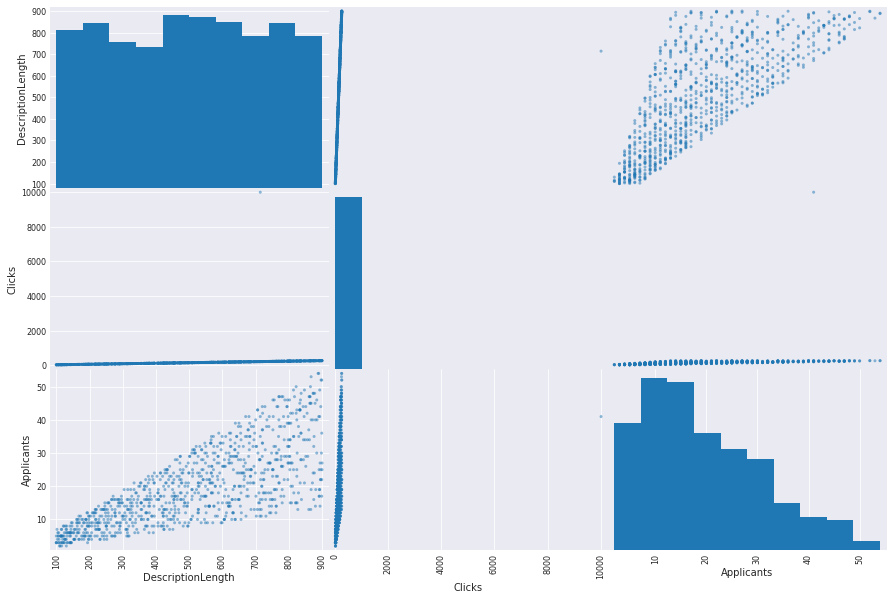

In [24]:
scatter_matrix(df[['DescriptionLength', 'Clicks', 'Applicants']], figsize=(15, 10))

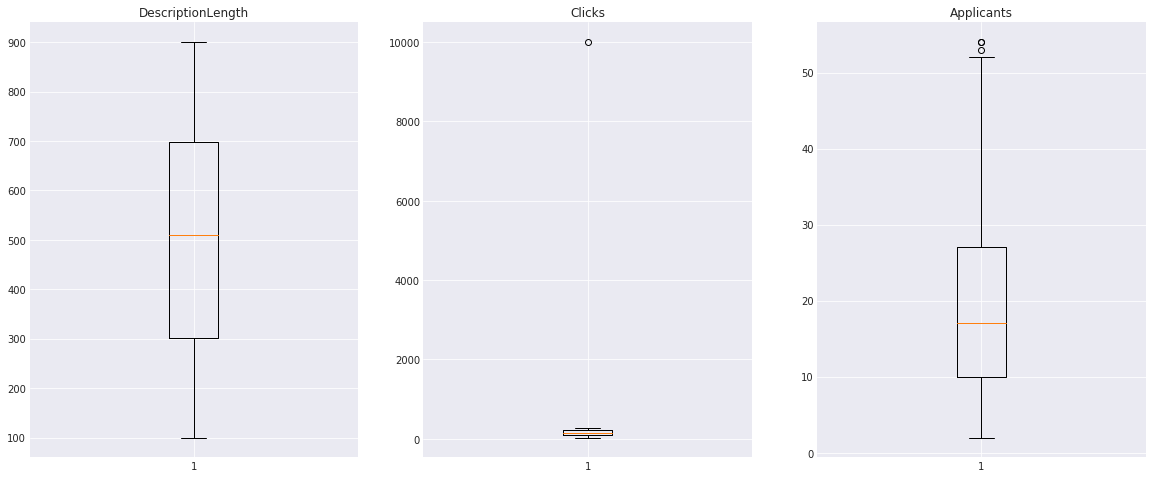

In [25]:
fig = plt.figure(figsize=(20, 8))
fig.add_subplot(1, 3, 1)
plt.boxplot(df.DescriptionLength)
plt.title('DescriptionLength')
# plot2 of changed beta
fig.add_subplot(1, 3, 2)
plt.boxplot(df.Clicks)
plt.title('Clicks')
# plot3 of changed beta
fig.add_subplot(1, 3, 3)
plt.boxplot(df.Applicants)
plt.title('Applicants')
# show plots
plt.show()

__Outliers observations identified in the plots__

We can identify in both plots a clear outlier which is the JobId with the __9999__ clicks. This outlier will bias our model significantly. The best way to deal with it is removing him from the dataset. Besided, there is not another outlier that we can identify, except a few high values of the Applicants variable which seems to be part of the population distribution.

In [26]:
# drop value 9999
df = df.loc[df.Clicks < 1000]
df.shape

(992, 8)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f32ca98f0b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f32ca7a30f0>]], dtype=object)

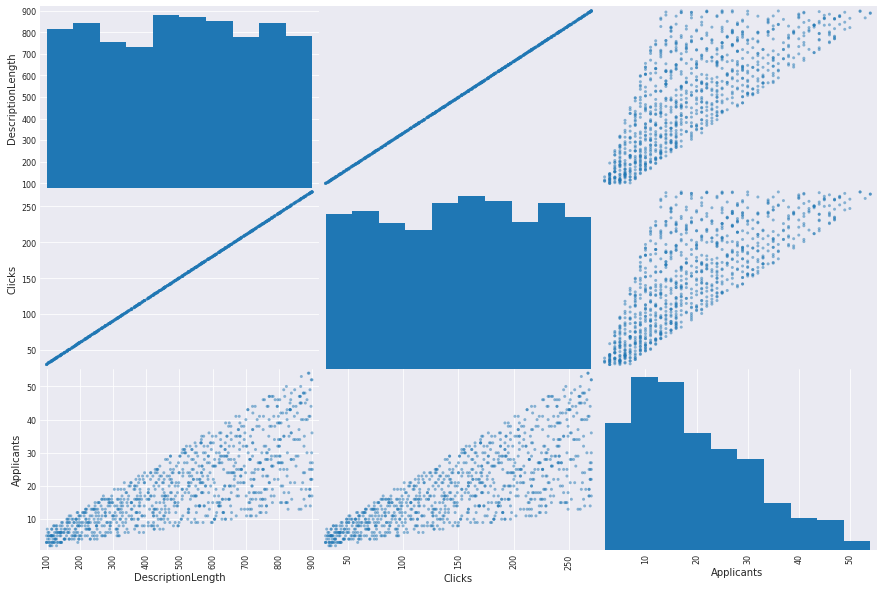

In [27]:
scatter_matrix(df[['DescriptionLength', 'Clicks', 'Applicants']], figsize=(15, 10))

After removing the outlier we can see a better picture of the variables relations. 

Something we can identify now immediately is a string linear connection between DescriptionLength and Clicks.

### 3. Target variables transforamtions
At this part we will analyse the targets variables and see if there is a need of some transformations.

__Applicants__

First, we want to see if this target variable is Normally distributed. If not, we would like to transform it and make it as Normally as posible. The reason behind it for having a better linear prediction model we need the target variable to be Normal. We will 
plot aa histogram and a QQ-Plot to see how Normal is the variable.

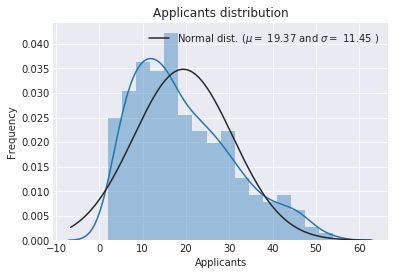

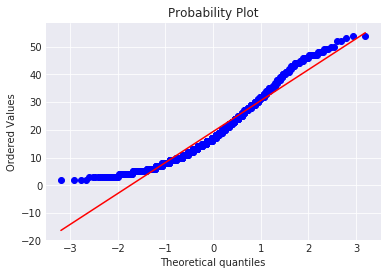

In [28]:
sns.distplot(df.Applicants, fit=norm)

# get the fitted parameters used by the function
(mu, sigma) = norm.fit(df.Applicants)

# now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
           loc='best')
plt.ylabel('Frequency')
plt.title('Applicants distribution')

# get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df.Applicants, plot=plt)
plt.show()

In [29]:
# KS-test for normality with 5% significance
stats.kstest(df.Applicants, 'norm')

KstestResult(statistic=0.99461784390385377, pvalue=0.0)

We can infer from the plots  and the KS-test for Normallity (P-value<0.05) that this variable is right skewed. Now we need to use some transformation, which  

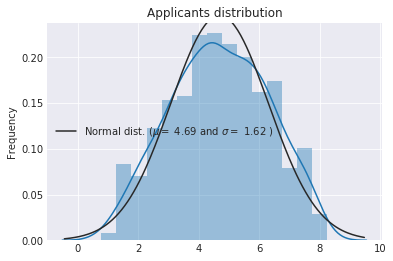

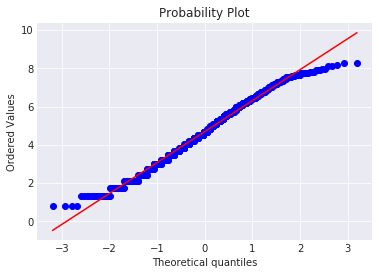

In [30]:
b_cox, _ = stats.boxcox(df.Applicants)
sns.distplot(b_cox, fit=norm)

# get the fitted parameters used by the function
(mu, sigma) = norm.fit(b_cox)

# now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
           loc='best')
plt.ylabel('Frequency')
plt.title('Applicants distribution')

# get also the QQ-plot
fig = plt.figure()
res = stats.probplot(b_cox, plot=plt)
plt.show()

In [31]:
stats.kstest(b_cox, 'norm')

KstestResult(statistic=0.9377282029803875, pvalue=0.0)

Conclusion:

Although the variable after the transfomations being made don't match the normal distribution (KS-test reject normality and QQ-plot has outliers), the distribution looks much more simmilar to the normal distribution than before.

In [38]:
# apply the box-cox transformation on this variable
df.Applicants, Applicants_lambda = stats.boxcox(df.Applicants)

__Clicks__

We will repeat the same procedure as the first target variable.

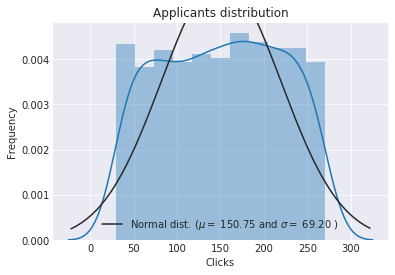

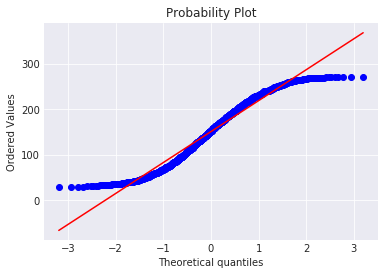

In [39]:
sns.distplot(df.Clicks, fit=norm)

# get the fitted parameters used by the function
(mu, sigma) = norm.fit(df.Clicks)

# now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
           loc='best')
plt.ylabel('Frequency')
plt.title('Applicants distribution')

# get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df.Clicks, plot=plt)
plt.show()

Result:

The Clicks target variable seems to be not normaly distributed at all. Any transforamtion won't help him more normaly distributed. For the 
meantime, we will leave as it is.

Another reason why we should not "touch" this target variable the strong linear relation we found earlier. Lets see what is the pearson correlation value to strength our intuition.

In [45]:
stats.pearsonr(df.DescriptionLength, df.Clicks)

(0.99999126266112726, 0.0)

This is a very high correlation as aspected.

### 4. Features engeneering
The features engeneering will be splited to two models: Clicks and Applicants predictions.

__Clicks__

As seen, we have almost a perfect correlation and a strong linear connection between DescriptionLength and Clicks.
The thing we should consider is removing other variables for improving the model overfeating. We will check if the other features add us any information.

In [353]:
# create seperate datframe
df_Clicks = df.drop('Applicants', axis=1)
list(df_Clicks)

['JobTitleId',
 'CategoryId',
 'City',
 'State',
 'DescriptionLength',
 'EducationLevel',
 'Clicks']

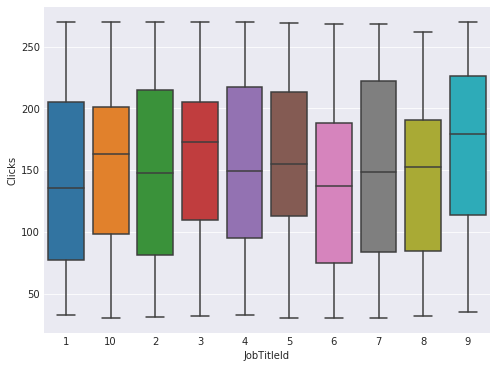

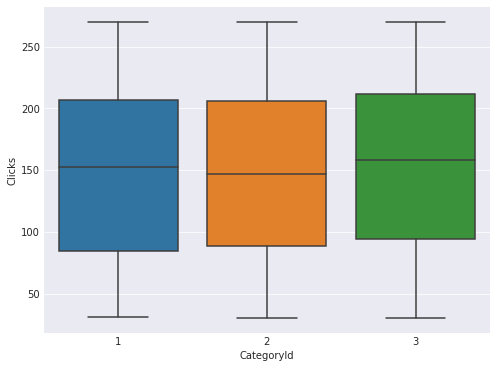

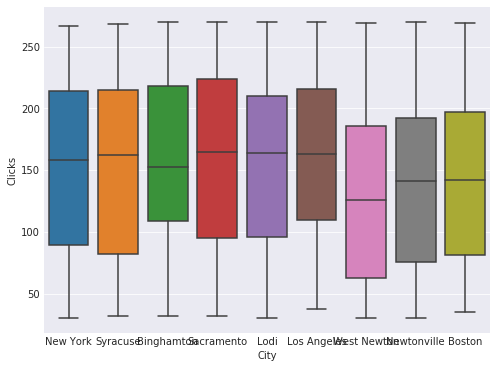

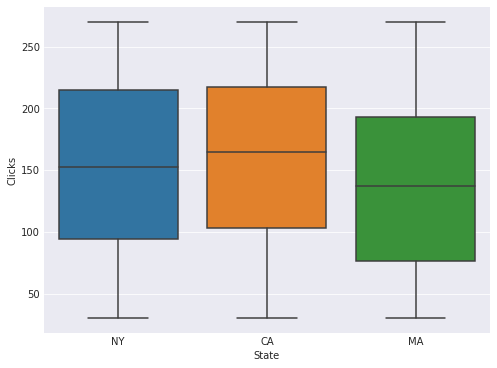

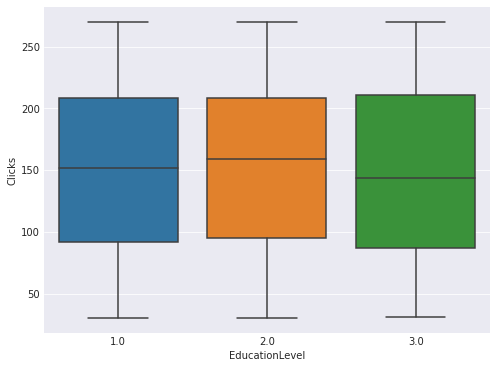

In [354]:
# boxplot of clicks explained by categories
clicks_columns = ['JobTitleId',
                  'CategoryId',
                  'City',
                  'State',
                  'EducationLevel']
for column in clicks_columns:
    f, ax = plt.subplots(figsize=(8, 6))
    fig = sns.boxplot(x=column, y="Clicks", data=df_Clicks)

In [355]:
df_Clicks = df_Clicks[['State', 'DescriptionLength', 'Clicks']]

__Decision__

All the categorical variables don't add any information to us, but still i would like to keep the State variable as Ma State add us a bot information.

__Applicants__

As the target variable is less correlated with the other features, we should find any needed transformation to featuresand find some interactions between features (with DescriptionLength).

In [356]:
# create seperate datframe
df_Applicants = df.drop('Clicks', axis=1)
list(df_Applicants)

['JobTitleId',
 'CategoryId',
 'City',
 'State',
 'DescriptionLength',
 'EducationLevel',
 'Applicants']

__Log transform__

It looks like we should perform some log tranform of the DescriptionLength feature to have a more linear connection to the Applicants target variable. Right now it looks 

(0.79200821498214202, 2.1937222760206438e-214)


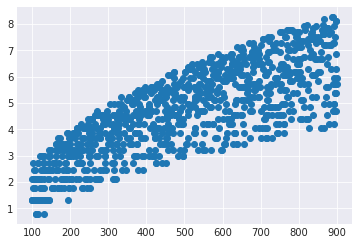

In [357]:
print(stats.pearsonr(df_Applicants.DescriptionLength, df_Applicants.Applicants))
plt.scatter(df_Applicants.DescriptionLength, df_Applicants.Applicants)

(0.80120365305386232, 5.1973176439995561e-223)


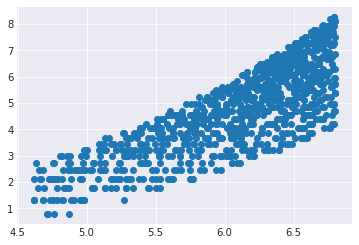

In [358]:
df_Applicants.DescriptionLength = np.log1p(df_Applicants.DescriptionLength)
print(stats.pearsonr(df_Applicants.DescriptionLength, df_Applicants.Applicants))
plt.scatter(df_Applicants.DescriptionLength, df_Applicants.Applicants)

Looks much better. It has a better linear shape.

__Interaction variables__

We should search some interactions of the categorical features with DescriptionLength as it may add us some information and improve the model.

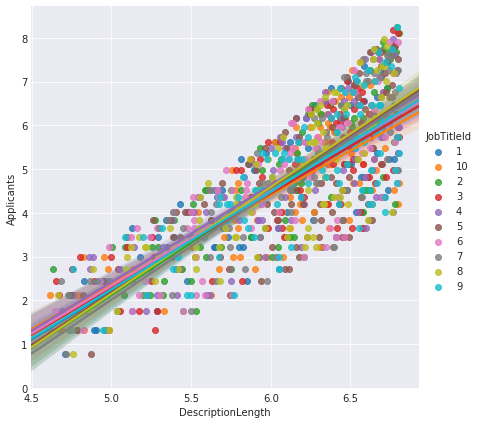

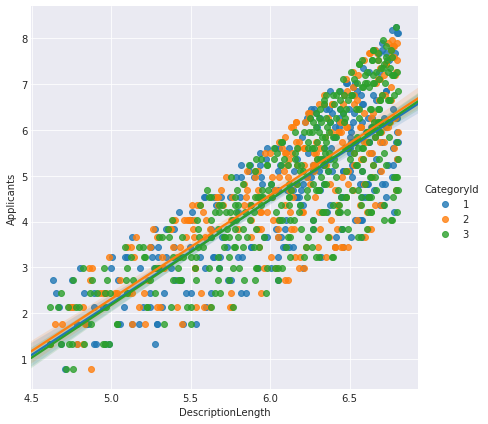

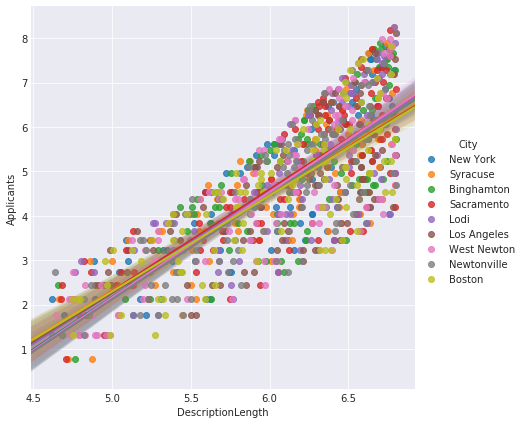

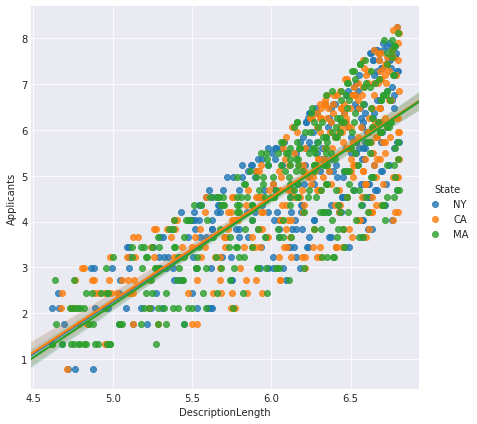

In [359]:
Applicants_columns = ['JobTitleId',
                      'CategoryId',
                      'City',
                      'State']
for column in Applicants_columns:
    sns.lmplot(x="DescriptionLength", y="Applicants", hue=column,data=df_Applicants, size=6)

__Decision__

There is no significant interaction to any of the features except maybe the JobTitleId feature. We will try to use this 

### 5. Dummy variables
For the purpose of using the categorical variables, we must encode them somehow. My first choice will be dummy variables with 
dropping the first level.

In [411]:
df_Clicks = pd.get_dummies(df_Clicks, drop_first=True)
print('Dataset number of rows - {}\n'
      'Dataset number of columns - {}\n'.format(df_Clicks.shape[0], df_Clicks.shape[1]))
print('Columns names:\n {}'.format(list(df_Clicks)))

Dataset number of rows - 992
Dataset number of columns - 4

Columns names:
 ['DescriptionLength', 'Clicks', 'State_MA', 'State_NY']


In [412]:
df_Applicants = pd.get_dummies(df_Applicants, drop_first=True)
df_Applicants['JobTitleId_11'] = 0
print('Dataset number of rows - {}\n'
      'Dataset number of columns - {}\n'.format(df_Applicants.shape[0], df_Applicants.shape[1]))
print('Columns names:\n {}'.format(list(df_Applicants)))

Dataset number of rows - 992
Dataset number of columns - 35

Columns names:
 ['DescriptionLength', 'EducationLevel', 'Applicants', 'JobTitleId_10', 'JobTitleId_2', 'JobTitleId_3', 'JobTitleId_4', 'JobTitleId_5', 'JobTitleId_6', 'JobTitleId_7', 'JobTitleId_8', 'JobTitleId_9', 'CategoryId_2', 'CategoryId_3', 'City_Boston', 'City_Lodi', 'City_Los Angeles', 'City_New York', 'City_Newtonville', 'City_Sacramento', 'City_Syracuse', 'City_West Newton', 'State_MA', 'State_NY', 'JobTitleId_11', 'JobTitleId_2_Description', 'JobTitleId_3_Description', 'JobTitleId_4_Description', 'JobTitleId_5_Description', 'JobTitleId_6_Description', 'JobTitleId_7_Description', 'JobTitleId_8_Description', 'JobTitleId_9_Description', 'JobTitleId_10_Description', 'JobTitleId_11_Description']


In [413]:
# create interaction features
df_Applicants['JobTitleId_2_Description'] = df_Applicants.JobTitleId_2*df_Applicants.DescriptionLength
df_Applicants['JobTitleId_3_Description'] = df_Applicants.JobTitleId_3*df_Applicants.DescriptionLength
df_Applicants['JobTitleId_4_Description'] = df_Applicants.JobTitleId_4*df_Applicants.DescriptionLength
df_Applicants['JobTitleId_5_Description'] = df_Applicants.JobTitleId_5*df_Applicants.DescriptionLength
df_Applicants['JobTitleId_6_Description'] = df_Applicants.JobTitleId_6*df_Applicants.DescriptionLength
df_Applicants['JobTitleId_7_Description'] = df_Applicants.JobTitleId_7*df_Applicants.DescriptionLength
df_Applicants['JobTitleId_8_Description'] = df_Applicants.JobTitleId_8*df_Applicants.DescriptionLength
df_Applicants['JobTitleId_9_Description'] = df_Applicants.JobTitleId_9*df_Applicants.DescriptionLength
df_Applicants['JobTitleId_10_Description'] = df_Applicants.JobTitleId_10*df_Applicants.DescriptionLength
df_Applicants['JobTitleId_11_Description'] = df_Applicants.JobTitleId_11*df_Applicants.DescriptionLength
print('Dataset number of rows - {}\n'
      'Dataset number of columns - {}\n'.format(df_Applicants.shape[0], df_Applicants.shape[1]))
print('Columns names:\n {}'.format(list(df_Applicants)))

Dataset number of rows - 992
Dataset number of columns - 35

Columns names:
 ['DescriptionLength', 'EducationLevel', 'Applicants', 'JobTitleId_10', 'JobTitleId_2', 'JobTitleId_3', 'JobTitleId_4', 'JobTitleId_5', 'JobTitleId_6', 'JobTitleId_7', 'JobTitleId_8', 'JobTitleId_9', 'CategoryId_2', 'CategoryId_3', 'City_Boston', 'City_Lodi', 'City_Los Angeles', 'City_New York', 'City_Newtonville', 'City_Sacramento', 'City_Syracuse', 'City_West Newton', 'State_MA', 'State_NY', 'JobTitleId_11', 'JobTitleId_2_Description', 'JobTitleId_3_Description', 'JobTitleId_4_Description', 'JobTitleId_5_Description', 'JobTitleId_6_Description', 'JobTitleId_7_Description', 'JobTitleId_8_Description', 'JobTitleId_9_Description', 'JobTitleId_10_Description', 'JobTitleId_11_Description']


### 6. Train Test spliting
A final step of spliting the data to a train and test is a must. The dataset will be splited 80% - 20%.

In [414]:
# Clicks
train_Clicks, test_Clicks = train_test_split(df_Clicks, test_size=0.2)
print('Train set shape: {}'.format(train_Clicks.shape))
print('Test set shape: {}'.format(test_Clicks.shape))

Train set shape: (793, 4)
Test set shape: (199, 4)


In [415]:
# Applicants
train_Applicants, test_Applicants = train_test_split(df_Applicants, test_size=0.2)
print('Train set shape: {}'.format(train_Applicants.shape))
print('Test set shape: {}'.format(test_Applicants.shape))

Train set shape: (793, 35)
Test set shape: (199, 35)


## Models building

### Libraries Import

In [416]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge

### Clicks prediction
We will start with the simple and full model and if needed we will try improve the model.

In [366]:
import statsmodels.api as sm

X_train_Clicks = train_Clicks.drop('Clicks', axis=1)
X_train_Clicks = sm.add_constant(X_train_Clicks)
Y_train_Clicks = train_Clicks.Clicks

X_test_Clicks = test_Clicks.drop('Clicks', axis=1)
X_test_Clicks = sm.add_constant(X_test_Clicks)
Y_test_Clicks = test_Clicks.Clicks


In [367]:
# Note the difference in argument order
model = sm.OLS(Y_train_Clicks, X_train_Clicks).fit()
predictions_Clicks_train = model.predict(X_train_Clicks)
predictions_Clicks_test = model.predict(X_test_Clicks)

# train results
rmse_train = mean_squared_error(Y_train_Clicks, predictions_Clicks_train)
R2_train = r2_score(Y_train_Clicks, predictions_Clicks_train)
print('Train results: R^2={}, RMSE={}'.format(R2_train, rmse_train))

# train results
rmse_test = mean_squared_error(Y_test_Clicks, predictions_Clicks_test)
R2_test = r2_score(Y_test_Clicks, predictions_Clicks_test)
print('Train results: R^2={}, RMSE={}'.format(R2_test, rmse_test))

# Print out the statistics
model.summary()


Train results: R^2=0.9999827297697941, RMSE=0.08427636524653638
Train results: R^2=0.9999815153470797, RMSE=0.08126712471646355


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Clicks   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.523e+07
Date:                Wed, 06 Jun 2018   Prob (F-statistic):               0.00
Time:                        16:58:52   Log-Likelihood:                -144.41
No. Observations:                 793   AIC:                             296.8
Df Residuals:                     789   BIC:                             315.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4392      0.030     14.885      0.000       0.381       0.497
DescriptionLength     0.3000   4.47e-05   6711.945      0.000       0.300       0.300
State_MA              0.0213      0.025      0.843      0.400      -0.028       0.071
State_NY              0.0212      0.026      0.826      0.409      -0.029       0.072
==============================================================================
Omnibus:                      851.933   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.631
Skew:                           0.026   Prob(JB):                     6.14e-12
Kurtosis:                       1.751   Cond. No.                     2.02e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

__Model conclusion__

As we can see we got great results on the test set and there is no need for more improvment. This will be our final model to predict Clicks.

### Applicants prediction
We will start with the simple and full model and if needed we will try improve the model.

In [417]:
import statsmodels.api as sm

X_train_Applicants = train_Applicants.drop('Applicants', axis=1)
X_train_Applicants = sm.add_constant(X_train_Applicants)
Y_train_Applicants = train_Applicants.Applicants

X_test_Applicants = test_Applicants.drop('Applicants', axis=1)
X_test_Applicants = sm.add_constant(X_test_Applicants)
Y_test_Applicants = test_Applicants.Applicants


In [418]:
# Note the difference in argument order
model_Applicants = sm.OLS(Y_train_Applicants, X_train_Applicants).fit()
predictions_Applicants_train = model_Applicants.predict(X_train_Applicants)
predictions_Applicants_test = model_Applicants.predict(X_test_Applicants)

# train results
rmse_train_Applicants = mean_squared_error(Y_train_Applicants, predictions_Applicants_train)
R2_train_Applicants = r2_score(Y_train_Applicants, predictions_Applicants_train)
print('Train results: R^2={}, RMSE={}'.format(R2_train_Applicants, rmse_train_Applicants))

# train results
rmse_test_Applicants = mean_squared_error(Y_test_Applicants, predictions_Applicants_test)
R2_test_Applicants = r2_score(Y_test_Applicants, predictions_Applicants_test)
print('Train results: R^2={}, RMSE={}'.format(R2_test_Applicants, rmse_test_Applicants))

# Print out the statistics
model_Applicants.summary()


Train results: R^2=0.6503173650097678, RMSE=0.9052056684667484
Train results: R^2=0.6246250126917878, RMSE=1.0468495459421001


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Applicants   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     50.74
Date:                Wed, 06 Jun 2018   Prob (F-statistic):          1.37e-153
Time:                        18:31:24   Log-Likelihood:                -1085.7
No. Observations:                 793   AIC:                             2229.
Df Residuals:                     764   BIC:                             2365.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -7.2019      0.909     -7.923      0.000      -8.986      -5.418
DescriptionLength             2.1902      0.181     12.109      0.000       1.835       2.545
EducationLevel                0.0262      0.044      0.594      0.553      -0.060       0.113
JobTitleId_10                 1.6609      1.076      1.544      0.123      -0.451       3.772
JobTitleId_2                 -0.6354      1.548     -0.410      0.682      -3.674       2.404
JobTitleId_3                  0.5099      1.589      0.321      0.748      -2.609       3.628
JobTitleId_4                 -0.0144      1.096     -0.013      0.990      -2.165       2.137
JobTitleId_5                 -0.7134      1.079     -0.661      0.509      -2.831       1.404
JobTitleId_6                  0.1221      0.991      0.123      0.902      -1.824       2.068
JobTitleId_7                 -1.3955      1.081     -1.291      0.197      -3.517       0.726
JobTitleId_8                 -0.4082      1.101     -0.371      0.711      -2.570       1.754
JobTitleId_9                 -0.5157      1.222     -0.422      0.673      -2.915       1.884
CategoryId_2                 -0.6057      0.978     -0.619      0.536      -2.525       1.314
CategoryId_3                 -0.6585      1.008     -0.653      0.514      -2.638       1.321
City_Boston                  -0.4673      0.100     -4.680      0.000      -0.663      -0.271
City_Lodi                    -1.4343      0.209     -6.847      0.000      -1.845      -1.023
City_Los Angeles             -1.6305      0.217     -7.517      0.000      -2.056      -1.205
City_New York                 0.0355      0.148      0.240      0.810      -0.255       0.326
City_Newtonville             -0.3771      0.096     -3.911      0.000      -0.566      -0.188
City_Sacramento              -1.4362      0.212     -6.768      0.000      -1.853      -1.020
City_Syracuse                -0.0013      0.147     -0.009      0.993      -0.290       0.287
City_West Newton             -0.3347      0.095     -3.539      0.000      -0.520      -0.149
State_MA                     -1.1791      0.146     -8.073      0.000      -1.466      -0.892
State_NY                     -1.5219      0.216     -7.036      0.000      -1.946      -1.097
JobTitleId_11             -3.357e-16   2.42e-16     -1.389      0.165    -8.1e-16    1.39e-16
JobTitleId_2_Description      0.1134      0.255      0.444      0.657      -0.388       0.615
JobTitleId_3_Description     -0.0783      0.260     -0.301      0.763      -0.589       0.432
JobTitleId_4_Description      0.1461      0.279      0.523      0.601      -0.402       0.695
JobTitleId_5_Description      0.2442      0.273      0.893      0.372      -0.292       0.781
JobTitleId_6_Description      0.0945      0.260      0.364      0.716      

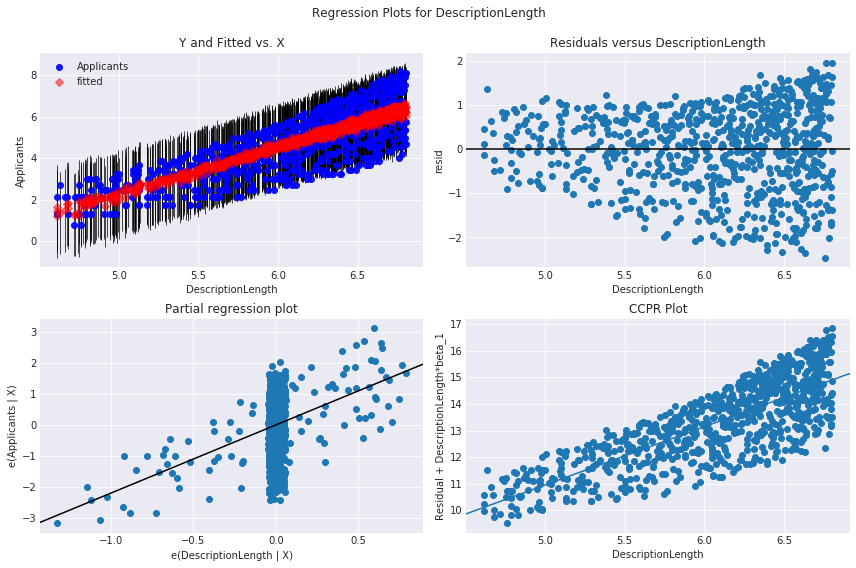

In [419]:
# plot the test results as a function of DescriptionLength
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model_Applicants, "DescriptionLength", fig=fig)

In [422]:
X_train_Applicants.shape

(793, 35)

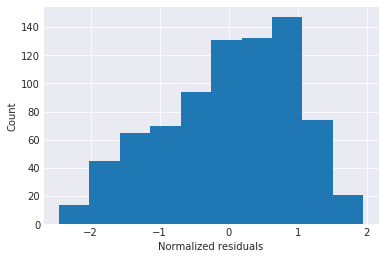

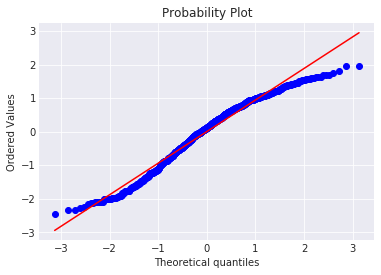

In [420]:
# Residuals historgram
plt.hist(model_Applicants.resid)
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

fig = plt.figure()
res = stats.probplot(model_Applicants.resid, plot=plt)
plt.show()

__Results__

This model results are not so good. The residuals are not perfectly normal distributed and with greater values of DescriptionLength we get higher variance. We will try improve the model predictions with Lasso Regression and Ridge Regression using 5-flods CV. We will concentrate on the RMSE measure for comparing the models.

## Improving Models

__Lasso__

Using Lasso model we can rid of some of the features and strength other using the alpha hyperparameter.

In [372]:
lasso = Lasso(random_state=0)
alphas = np.logspace(-10, 2, 50)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf_lasso = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=True, scoring='mean_squared_error')
clf_lasso.fit(X_train_Applicants, Y_train_Applicants)


GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([  1.00000e-10,   1.75751e-10,   3.08884e-10,   5.42868e-10,
         9.54095e-10,   1.67683e-09,   2.94705e-09,   5.17947e-09,
         9.10298e-09,   1.59986e-08,   2.81177e-08,   4.94171e-08,
         8.68511e-08,   1.52642e-07,   2.68270e-07,   4.71487e-07,
         8...   5.96362e+00,   1.04811e+01,   1.84207e+01,   3.23746e+01,
         5.68987e+01,   1.00000e+02])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='mean_squared_error', verbose=0)

In [373]:
train_rmse_lasso = np.sqrt(clf_lasso.best_score_*(-1))
print('Lasso regression train results: RMSE = {}'.format(train_rmse_lasso))

Lasso regression train results: RMSE = 0.9813340216346067


In [374]:
pred_lasso = clf_lasso.predict(X_test_Applicants)
test_rmse_lasso = np.sqrt(mean_squared_error(Y_test_Applicants, pred_lasso))
print('Lasso regression test results: RMSE = {}'.format(test_rmse_lasso))

Lasso regression test results: RMSE = 0.9846666954153173


__Rigid__

This model also use the alpha hyperparameter but for the purpose of shrinkin hte model coeficients.


In [375]:
ridge = Ridge(random_state=0)
alphas = np.logspace(-5, -1, 50)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf_rigid = GridSearchCV(ridge, tuned_parameters, cv=n_folds, refit=True, scoring='mean_squared_error')
clf_rigid.fit(X_train_Applicants, Y_train_Applicants)


GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=0, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([  1.00000e-05,   1.20679e-05,   1.45635e-05,   1.75751e-05,
         2.12095e-05,   2.55955e-05,   3.08884e-05,   3.72759e-05,
         4.49843e-05,   5.42868e-05,   6.55129e-05,   7.90604e-05,
         9.54095e-05,   1.15140e-04,   1.38950e-04,   1.67683e-04,
         2...   3.90694e-02,   4.71487e-02,   5.68987e-02,   6.86649e-02,
         8.28643e-02,   1.00000e-01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='mean_squared_error', verbose=0)

In [376]:
train_rmse_rigid = np.sqrt(clf_rigid.best_score_*(-1))
print('Rigid regression train results: RMSE = {}'.format(train_rmse_rigid))


Rigid regression train results: RMSE = 1.0028761617372395


In [377]:
pred_rigid = clf_rigid.predict(X_test_Applicants)
test_rmse_rigid = np.sqrt(mean_squared_error(Y_test_Applicants, pred_rigid))
print('Rigid regression test results: RMSE = {}'.format(test_rmse_rigid))

Rigid regression test results: RMSE = 1.0170265937672538


__Conclusion__

We have not succeed improving our Applicants model. I will choose the intial model for the predictions purpose.

## Prediction
We will use the chosen models to predict today 2 jobs.

### final models
We will take the chosen models and fit them on all the data. After fitting we can make the prediction.

__Clicks__

In [335]:
X_final_Clicks = df_Clicks.drop('Clicks', axis=1)
X_final_Clicks = sm.add_constant(X_final_Clicks)
Y_final_Clicks = df_Clicks.Clicks
model_Clicks_final = sm.OLS(Y_final_Clicks, X_final_Clicks).fit()
model_Clicks_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Clicks   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.886e+07
Date:                Wed, 06 Jun 2018   Prob (F-statistic):               0.00
Time:                        16:38:55   Log-Likelihood:                -176.70
No. Observations:                 992   AIC:                             361.4
Df Residuals:                     988   BIC:                             381.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4429      0.027     16.671      0.000       0.391       0.495
DescriptionLength     0.3000   4.02e-05   7466.407      0.000       0.300       0.300
State_MA              0.0091      0.023      0.405      0.686      -0.035       0.053
State_NY              0.0214      0.023      0.945      0.345      -0.023       0.066
==============================================================================
Omnibus:                     1217.507   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.223
Skew:                           0.003   Prob(JB):                     6.87e-15
Kurtosis:                       1.744   Cond. No.                     2.03e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [305]:
list(X_final_Clicks)

['const', 'DescriptionLength', 'State_MA', 'State_NY']

In [429]:
# today data to predict dataframe
data = {'JobId': [1001, 1002],'DescriptionLength': [314,199], 
        'State_MA': [0,0], 'State_NY': [1,1], 'const': [1.0,1.0]}
df_to_predict_Clicks = pd.DataFrame(data, columns = ['JobId', 'const',
                                                     'DescriptionLength', 'State_MA',
                                                     'State_NY'])
# predict data
df_to_predict_Clicks['predictions_Clicks'] = np.round(model_Clicks_final.predict(df_to_predict_Clicks.iloc[:,1:]))
df_to_predict_Clicks

,JobId,const,DescriptionLength,State_MA,State_NY,predictions_Clicks
0,1001,1.0,314,0,1,95.0
1,1002,1.0,199,0,1,60.0


__Applicants__

In [400]:
X_final_Applicants = df_Applicants.drop('Applicants', axis=1)
X_final_Applicants = sm.add_constant(X_final_Applicants)
Y_final_Applicants = df_Applicants.Applicants
model_Applicants_final = sm.OLS(Y_final_Applicants, X_final_Applicants).fit()
model_Applicants_final.summary()

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Applicants   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     63.06
Date:                Wed, 06 Jun 2018   Prob (F-statistic):          8.12e-196
Time:                        18:21:18   Log-Likelihood:                -1370.6
No. Observations:                 992   AIC:                             2799.
Df Residuals:                     963   BIC:                             2941.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -7.4240      0.831     -8.933      0.000      -9.055      -5.793
DescriptionLength             2.2395      0.166     13.493      0.000       1.914       2.565
EducationLevel                0.0102      0.039      0.260      0.795      -0.067       0.088
JobTitleId_10                 1.3900      0.978      1.421      0.156      -0.530       3.310
JobTitleId_2                 -0.8687      1.439     -0.604      0.546      -3.693       1.955
JobTitleId_3                  0.6135      1.444      0.425      0.671      -2.220       3.447
JobTitleId_4                  0.2783      0.921      0.302      0.763      -1.530       2.086
JobTitleId_5                 -0.7577      0.947     -0.800      0.424      -2.615       1.100
JobTitleId_6                  0.4442      0.906      0.490      0.624      -1.334       2.223
JobTitleId_7                 -0.9856      0.881     -1.118      0.264      -2.715       0.744
JobTitleId_8                 -0.8116      0.980     -0.828      0.408      -2.736       1.112
JobTitleId_9                  0.1717      1.094      0.157      0.875      -1.976       2.319
CategoryId_2                 -0.0352      0.882     -0.040      0.968      -1.766       1.696
CategoryId_3                 -0.2355      0.913     -0.258      0.796      -2.027       1.556
City_Boston                  -0.4339      0.090     -4.799      0.000      -0.611      -0.257
City_Lodi                    -1.5348      0.190     -8.058      0.000      -1.909      -1.161
City_Los Angeles             -1.6439      0.197     -8.357      0.000      -2.030      -1.258
City_New York                -0.0080      0.132     -0.060      0.952      -0.268       0.252
City_Newtonville             -0.4116      0.088     -4.702      0.000      -0.583      -0.240
City_Sacramento              -1.4913      0.192     -7.763      0.000      -1.868      -1.114
City_Syracuse                -0.0387      0.134     -0.290      0.772      -0.301       0.224
City_West Newton             -0.3550      0.086     -4.125      0.000      -0.524      -0.186
State_MA                     -1.2006      0.135     -8.924      0.000      -1.465      -0.937
State_NY                     -1.5534      0.198     -7.850      0.000      -1.942      -1.165
JobTitleId_11              5.605e-17   2.31e-16      0.242      0.809   -3.98e-16     5.1e-16
JobTitleId_2_Description      0.1544      0.237      0.651      0.515      -0.311       0.620
JobTitleId_3_Description     -0.1045      0.237     -0.441      0.659      -0.569       0.360
JobTitleId_4_Description     -0.0114      0.240     -0.047      0.962      -0.483       0.460
JobTitleId_5_Description      0.1524      0.245      0.622      0.534      -0.328       0.633
JobTitleId_6_Description     -0.0600      0.240     -0.250      0.802      

In [379]:
list(X_final_Applicants)

['const',
 'DescriptionLength',
 'EducationLevel',
 'JobTitleId_10',
 'JobTitleId_2',
 'JobTitleId_3',
 'JobTitleId_4',
 'JobTitleId_5',
 'JobTitleId_6',
 'JobTitleId_7',
 'JobTitleId_8',
 'JobTitleId_9',
 'CategoryId_2',
 'CategoryId_3',
 'City_Boston',
 'City_Lodi',
 'City_Los Angeles',
 'City_New York',
 'City_Newtonville',
 'City_Sacramento',
 'City_Syracuse',
 'City_West Newton',
 'State_MA',
 'State_NY',
 'JobTitleId_11',
 'JobTitleId_2_Description',
 'JobTitleId_3_Description',
 'JobTitleId_4_Description',
 'JobTitleId_5_Description',
 'JobTitleId_6_Description',
 'JobTitleId_7_Description',
 'JobTitleId_8_Description',
 'JobTitleId_9_Description',
 'JobTitleId_10_Description',
 'JobTitleId_11_Description']

In [433]:
# today data to predict dataframe
data_Applicants =   {'JobId':[1001, 1002],
                     'const':[1,1],
                     'DescriptionLength':[np.log1p(314),np.log1p(199)],
                     'EducationLevel':[2,1],
                     'JobTitleId_10': [0, 0],
                     'JobTitleId_2': [0, 0],
                     'JobTitleId_3': [0, 0],
                     'JobTitleId_4': [0, 0],
                     'JobTitleId_5': [0, 0],
                     'JobTitleId_6': [0, 0],
                     'JobTitleId_7': [0, 0],
                     'JobTitleId_8': [0, 0],
                     'JobTitleId_9': [0, 0],
                     'CategoryId_2': [0, 0],
                     'CategoryId_3': [0, 0],
                     'City_Boston': [0, 0],
                     'City_Lodi': [0, 0],
                     'City_Los Angeles': [0, 0],
                     'City_New York': [1, 1],
                     'City_Newtonville': [0, 0],
                     'City_Sacramento': [0, 0],
                     'City_Syracuse': [0, 0],
                     'City_West Newton': [0, 0],
                     'State_MA': [0, 0],
                     'State_NY': [1, 1],
                     'JobTitleId_11': [0, 1],
                     'JobTitleId_2_Description': [0, 0],
                     'JobTitleId_3_Description': [0, 0],
                     'JobTitleId_4_Description': [0, 0],
                     'JobTitleId_5_Description': [0, 0],
                     'JobTitleId_6_Description': [0, 0],
                     'JobTitleId_7_Description': [0, 0],
                     'JobTitleId_8_Description': [0, 0],
                     'JobTitleId_9_Description': [0, 0],
                     'JobTitleId_10_Description':[0, 0],
                     'JobTitleId_11_Description':[0, 199]}

df_to_predict_Applicants = pd.DataFrame(data_Applicants, 
                                        columns =   ['JobId',
                                                     'const',
                                                     'DescriptionLength',
                                                     'EducationLevel',
                                                     'JobTitleId_10',
                                                     'JobTitleId_2',
                                                     'JobTitleId_3',
                                                     'JobTitleId_4',
                                                     'JobTitleId_5',
                                                     'JobTitleId_6',
                                                     'JobTitleId_7',
                                                     'JobTitleId_8',
                                                     'JobTitleId_9',
                                                     'CategoryId_2',
                                                     'CategoryId_3',
                                                     'City_Boston',
                                                     'City_Lodi',
                                                     'City_Los Angeles',
                                                     'City_New York',
                                                     'City_Newtonville',
                                                     'City_Sacramento',
                                                     'City_Syracuse',
                                                     'City_West Newton',
                                                     'State_MA',
                                                     'State_NY',
                                                     'JobTitleId_11',
                                                     'JobTitleId_2_Description',
                                                     'JobTitleId_3_Description',
                                                     'JobTitleId_4_Description',
                                                     'JobTitleId_5_Description',
                                                     'JobTitleId_6_Description',
                                                     'JobTitleId_7_Description',
                                                     'JobTitleId_8_Description',
                                                     'JobTitleId_9_Description',
                                                     'JobTitleId_10_Description',
                                                     'JobTitleId_11_Description'])


df_to_predict_Applicants['predictions_Applicants'] = np.round(model_Applicants_final.predict(
                                                   df_to_predict_Applicants.iloc[:,1:]))
# predict and inversing the cox-box
df_to_predict_Applicants.predictions_Applicants = np.round(scipy.special.inv_boxcox(
                                                        df_to_predict_Applicants.predictions_Applicants, 
                                                        Applicants_lambda))

df_to_predict_Applicants[['JobId', 'predictions_Applicants']]

,JobId,predictions_Applicants
0,1001,13.0
1,1002,8.0


## Final prediction

In [434]:
df_to_predict_Clicks

,JobId,const,DescriptionLength,State_MA,State_NY,predictions_Clicks
0,1001,1.0,314,0,1,95.0
1,1002,1.0,199,0,1,60.0


In [435]:
df_to_predict_Applicants[['JobId', 'predictions_Applicants']]

,JobId,predictions_Applicants
0,1001,13.0
1,1002,8.0


### ** Note:
   
The might have problem as we predict an example we have never seen, The JobTitleId - 11. We should not extrapolate data as it probably won't be good enough. Yet, this is our test set and we must have some prediction. We can see the model refer to this variable, but with really small weights as it doesn't know what it's real value.


